<a href="https://colab.research.google.com/github/dineshb302/TERM2/blob/pushanb/MLUL_Assgnment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#import sklearn
#sklearn.__version__
#!pip install -U sklearn
#sklearn.__version__
## if the final version is 1.3 or higher uncomment HDBSCAN

In [ ]:
## Imports for clustering and visualization
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
#from sklearn.cluster import HDBSCAN  ## in Version 1.3 of sklearn

In [ ]:
## Imports for cluster evaluation
from yellowbrick.cluster import SilhouetteVisualizer

## Metric evaluation
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_file = 'gdrive/My Drive/Champo Carpets V1.csv'
Champo = pd.read_csv(data_file, encoding = 'UTF-8')
print("Shape: ",Champo.shape)
Champo.info()

Shape:  (13135, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderiD           13135 non-null  int64  
 1   Item_Id           13135 non-null  int64  
 2   CustomerCode      13135 non-null  object 
 3   CountryName       13135 non-null  object 
 4   customer_country  13135 non-null  object 
 5   QtyRequired       13135 non-null  int64  
 6   TotalArea         13135 non-null  float64
 7   Amount            13135 non-null  float64
 8   ITEM_NAME         13135 non-null  object 
 9   QualityName       13135 non-null  object 
 10  DesignName        13135 non-null  object 
 11  ColorName         13135 non-null  object 
 12  ShapeName         13135 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 1.3+ MB


In [ ]:
Champo.describe()

,OrderiD,Item_Id,QtyRequired,TotalArea,Amount
count,13135.000000,13135.000000,13135.000000,13135.000000,13135.000000
mean,3075.336962,14528.683746,44.460601,44.731370,2392.040164
std,2107.731646,13183.139544,228.749535,50.099597,16832.091080
min,1.000000,1.000000,1.000000,0.040000,0.000000
25%,1219.500000,3023.000000,3.000000,5.800000,163.200000
50%,2934.000000,8631.000000,8.000000,24.000000,590.625000
75%,4630.000000,26713.000000,20.000000,80.000000,1540.000000
max,7548.000000,46701.000000,6400.000000,1024.000000,599719.680000


In [ ]:
amt0 = Champo[(Champo['Amount']==0)]  ## Could be cases
print('amt0 shape: ',amt0.shape)
Champo1 = Champo[(Champo['Amount']>0)]
print('Champo1 shape: ', Champo1.shape)

amt0 shape:  (546, 13)
Champo1 shape:  (12589, 13)


In [ ]:
cust_uni_item = Champo1.groupby(['CustomerCode'])['Item_Id'].nunique().reset_index()
cust_uni_item.columns = ['CustomerCode','UniqueCount']
cust_uni_item[0:5]

,CustomerCode,UniqueCount
0,A-11,23
1,A-6,25
2,A-9,504
3,B-2,44
4,B-3,72


In [ ]:
cust_order_cnt = Champo1.groupby(['CustomerCode'])['OrderiD'].nunique().reset_index()
cust_order_cnt.columns = ['CustomerCode', 'Order_Count']
cust_order_cnt[0:5]

,CustomerCode,Order_Count
0,A-11,11
1,A-6,2
2,A-9,205
3,B-2,8
4,B-3,11


In [67]:
cust_amt_sum = Champo1.groupby(['CustomerCode'])['Amount'].sum().reset_index()
cust_amt_sum[0:5]

,CustomerCode,Amount
0,A-11,1.854041e+05
1,A-6,6.247460e+03
2,A-9,1.592080e+06
3,B-2,1.481116e+04
4,B-3,5.862686e+04


In [65]:
cust_spend_grp = cust_amt_sum
cust_spend_grp['SpenderGroup'] = pd.cut( cust_spend_grp['Amount'], [0, 1000 , 5000, 50000, 100000, 20000000], labels = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond'])
cust_spend_grp = cust_spend_grp.get(['CustomerCode','SpenderGroup'])
cust_spend_grp[0:5]

,CustomerCode,SpenderGroup
0,A-11,Diamond
1,A-6,Gold
2,A-9,Diamond
3,B-2,Gold
4,B-3,Platinum


In [68]:
cust_df = cust_order_cnt.merge(cust_amt_sum, on = 'CustomerCode').merge(cust_uni_item, on = 'CustomerCode')
cust_df.columns = ['CustomerCode','Quantity','Amount','UniqueItems']
print(cust_df.shape)
cust_df[0:5]

(45, 4)


,CustomerCode,Quantity,Amount,UniqueItems
0,A-11,11,1.854041e+05,23
1,A-6,2,6.247460e+03,25
2,A-9,205,1.592080e+06,504
3,B-2,8,1.481116e+04,44
4,B-3,11,5.862686e+04,72


Standard Scaling

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_scale_cust_df = scaler.fit_transform( cust_df[['Quantity',
                                                   'Amount',
                                                   'UniqueItems']] )

In [70]:
std_scale_cust_df = pd.DataFrame(std_scale_cust_df,
                                 columns = ['Quantity',
                                            'Amount',
                                            'UniqueItems'])
std_scale_cust_df[0:5]

,Quantity,Amount,UniqueItems
0,-0.363582,-0.286682,-0.628380
1,-0.448208,-0.386838,-0.616591
2,1.460595,0.499714,2.206993
3,-0.391791,-0.382051,-0.504590
4,-0.363582,-0.357556,-0.339537


Min-Max Scaling

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
min_max_scale_cust_df = scaler.fit_transform( cust_df[['Quantity',
                                                       'Amount',
                                                       'UniqueItems']] )

In [72]:
min_max_scale_cust_df = pd.DataFrame(min_max_scale_cust_df,
                                     columns = ['Quantity',
                                                'Amount',
                                                'UniqueItems'])
min_max_scale_cust_df[0:5]

,Quantity,Amount,UniqueItems
0,0.016529,0.016320,0.028947
1,0.001653,0.000522,0.031579
2,0.337190,0.140357,0.661842
3,0.011570,0.001277,0.056579
4,0.016529,0.005141,0.093421


Logarithmic scaling

In [76]:
Log_scale_cust_df = cust_df
Log_scale_cust_df['Quantity'] = np.log10(cust_df['Quantity'])
Log_scale_cust_df['Amount']   = np.log10(cust_df['Amount'])
Log_scale_cust_df['UniqueItems']   = np.log10(cust_df['UniqueItems'])
Log_scale_cust_df = Log_scale_cust_df.get(['Quantity','Amount','UniqueItems'])
Log_scale_cust_df[0:5]

,Quantity,Amount,UniqueItems
0,1.041393,5.268119,1.361728
1,0.301030,3.795703,1.397940
2,2.311754,6.201965,2.702431
3,0.903090,4.170589,1.643453
4,1.041393,4.768097,1.857332


In [ ]:
scale_cust_df = std_scale_cust_df

In [ ]:
kmn_df = scale_cust_df.get(['Quantity','Amount'])
kmn_df[0:5]

,Quantity,Amount
0,-0.512576,-0.286682
1,-0.544645,-0.386838
2,1.888300,0.499714
3,-0.497611,-0.382051
4,-0.444163,-0.357556


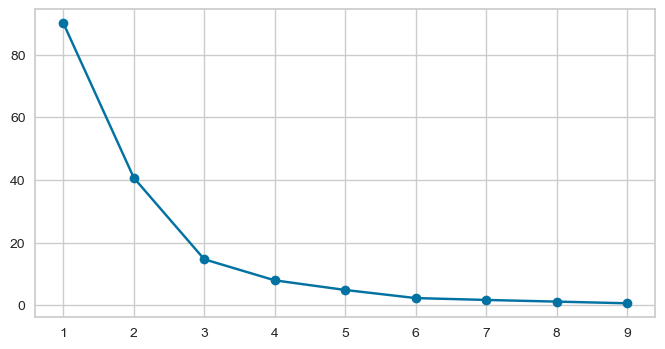

In [ ]:
## KMEANS Clustering -- Elbow method
cluster_range = range( 1, 10 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( kmn_df )
  cluster_errors.append( clusters.inertia_ )

plt.figure(figsize=(8,4))
plt.plot( cluster_range, cluster_errors, marker = "o" );

Evaluating the cluster with k in (4,5,6,7)

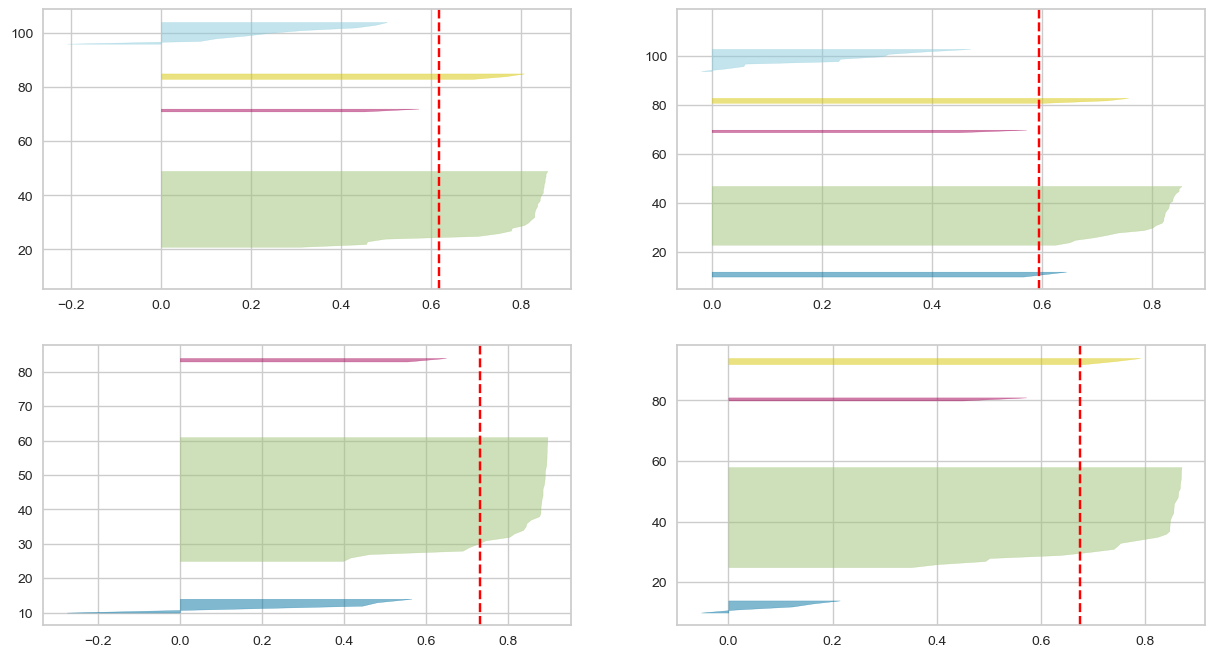

In [ ]:
## Silhouette Visualization

fig, ax = plt.subplots(2, 2, figsize=(15,8))
num_clusters = [4, 5, 6, 7]
for i, k in enumerate(num_clusters):
    km = KMeans(n_clusters=k,
                random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km,
                                      colors='yellowbrick',
                                      ax=ax[q-1][mod])
    visualizer.fit(kmn_df)

Creating 6 clusters

In [ ]:
k = 6

clusters = KMeans( k, random_state = 42 )
clusters.fit( kmn_df )

kmn_df[0:5]

,Quantity,Amount
0,-0.512576,-0.286682
1,-0.544645,-0.386838
2,1.888300,0.499714
3,-0.497611,-0.382051
4,-0.444163,-0.357556


Understanding the clusters.

In [ ]:
scale_cust_df['clusterid'] = clusters.labels_

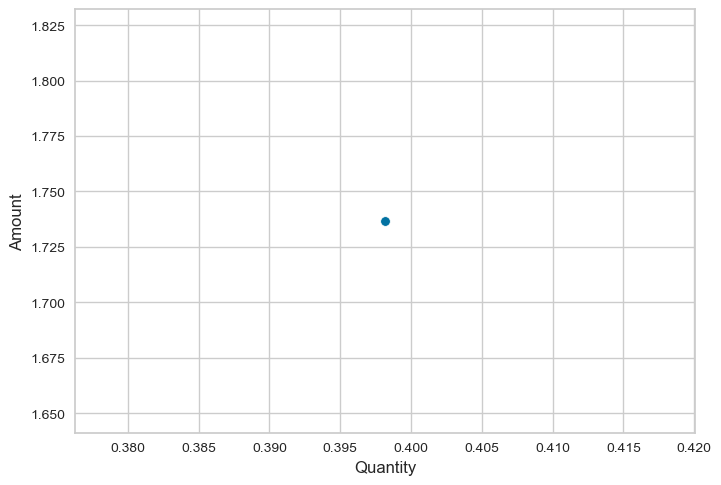

In [ ]:
## Cluster 0
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==0],
               x = 'Quantity',
               y = 'Amount' );

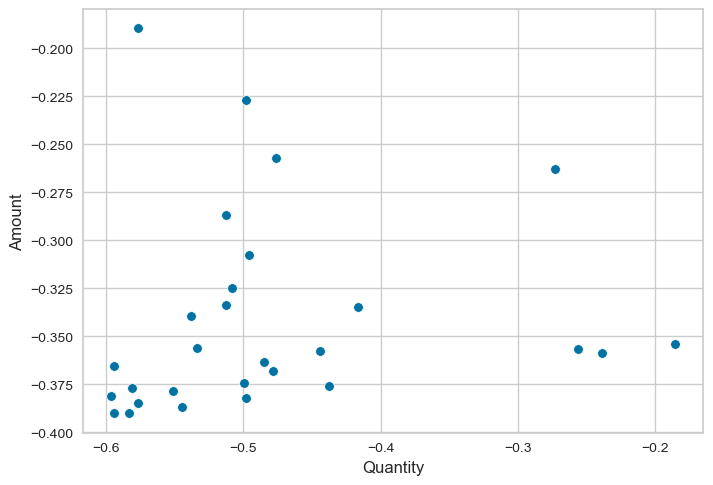

In [ ]:
## Cluster 1
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==1],
               x = 'Quantity',
               y = 'Amount' );

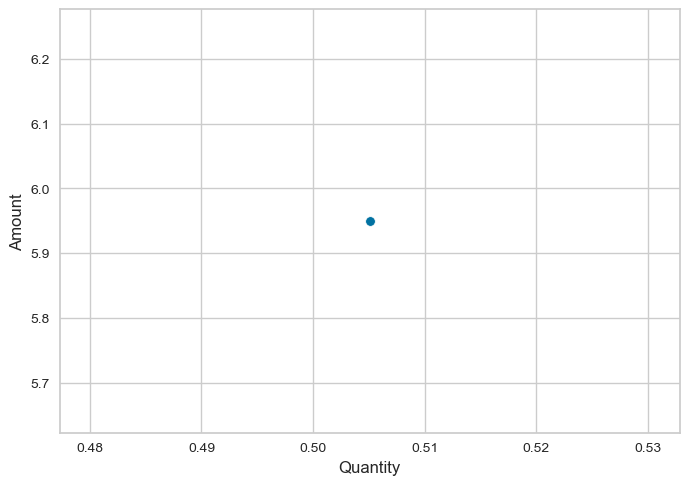

In [ ]:
## Cluster 2
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==2],
               x = 'Quantity',
               y = 'Amount' );

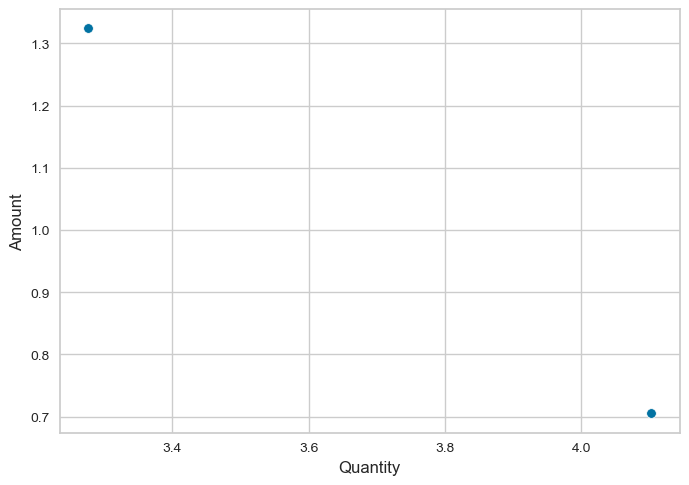

In [ ]:
## Cluster 3
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==3],
               x = 'Quantity',
               y = 'Amount' );

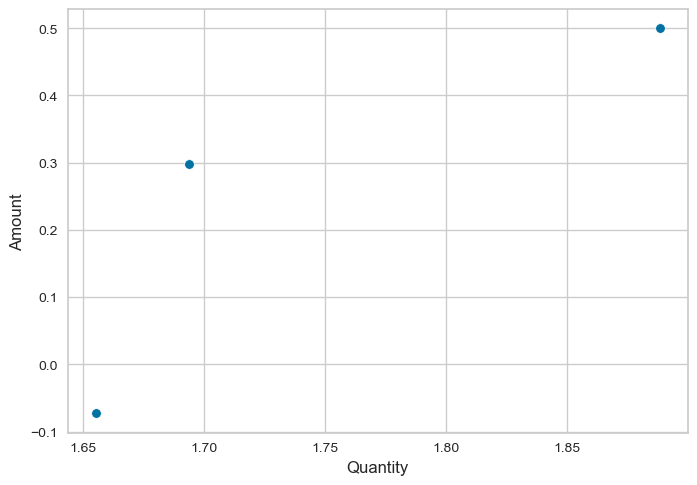

In [ ]:
## Cluster 4
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==4],
               x = 'Quantity',
               y = 'Amount' );

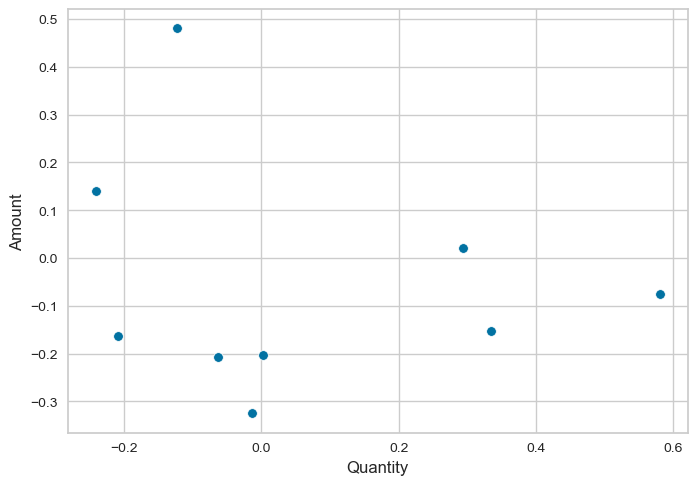

In [ ]:
## Cluster 5
sn.scatterplot(data = scale_cust_df[scale_cust_df['clusterid']==5],
               x = 'Quantity',
               y = 'Amount' );

Evalauating the clusters

In [ ]:
## Calinski-Harabasz Index => Relative measure (higher the value greater is the clustering performance)

cluster_range = range( 4, 8 )
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( kmn_df )
  print(f"n_cluster: {num_clusters} - CH Score: {calinski_harabasz_score(kmn_df, clusters.labels_)}" )

n_cluster: 4 - CH Score: 189.92459966198393
n_cluster: 5 - CH Score: 256.7431846230788
n_cluster: 6 - CH Score: 744.761172898027
n_cluster: 7 - CH Score: 794.0811723896935


In [ ]:
## Davies-Bouldin Index => lower value means better clustering

cluster_range = range( 4, 8 )
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( kmn_df )
  print(f"n_cluster: {num_clusters} - CH Score: {davies_bouldin_score(kmn_df, clusters.labels_)}" )

n_cluster: 4 - CH Score: 0.3879200256023856
n_cluster: 5 - CH Score: 0.23319154813437254
n_cluster: 6 - CH Score: 0.2093595276078477
n_cluster: 7 - CH Score: 0.1391286994654189


Hierarchical Clustering

In [ ]:
## Agglomerative Clustering using euclidean

h_cluster = AgglomerativeClustering(n_clusters = 6,
                                    metric = 'euclidean',
                                    linkage = 'ward',           ## minimizes the variance of the clusters being merged
                                    compute_distances = True)

In [ ]:
h_cluster.fit(kmn_df)

AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=6)

In [ ]:
scale_cust_df['hcluster_clusterid'] = h_cluster.labels_
scale_cust_df[0:5]

,Quantity,Amount,clusterid,hcluster_clusterid
0,-0.512576,-0.286682,1,2
1,-0.544645,-0.386838,1,2
2,1.888300,0.499714,4,3
3,-0.497611,-0.382051,1,2
4,-0.444163,-0.357556,1,2


In [ ]:
h_cluster.n_leaves_

45

In [ ]:
h_cluster.children_

array([[22, 42],
       [15, 44],
       [ 3, 11],
       [16, 34],
       [13, 41],
       [ 1, 23],
       [14, 45],
       [10, 48],
       [24, 37],
       [21, 36],
       [ 4,  5],
       [51, 52],
       [ 0,  9],
       [25, 56],
       [46, 47],
       [30, 39],
       [49, 53],
       [ 8, 55],
       [28, 35],
       [50, 58],
       [17, 54],
       [57, 61],
       [59, 62],
       [32, 33],
       [26, 60],
       [12, 63],
       [66, 67],
       [19, 40],
       [65, 68],
       [69, 71],
       [ 2, 20],
       [38, 72],
       [64, 74],
       [ 7, 29],
       [70, 73],
       [ 6, 75],
       [27, 31],
       [78, 79],
       [76, 82],
       [77, 83],
       [18, 80],
       [81, 85],
       [43, 86],
       [84, 87]], dtype=int64)

In [ ]:
h_cluster.distances_

array([1.95090265e-04, 7.83832937e-03, 8.02548326e-03, 8.42785334e-03,
       9.58770303e-03, 1.06713015e-02, 1.07547580e-02, 1.20580352e-02,
       1.69769164e-02, 1.71928369e-02, 1.92068351e-02, 2.52387679e-02,
       2.71991151e-02, 2.73308003e-02, 2.97929678e-02, 3.71305817e-02,
       4.47348675e-02, 4.62841025e-02, 6.63588393e-02, 7.13782611e-02,
       7.17363010e-02, 7.44030528e-02, 1.10266579e-01, 1.17721803e-01,
       1.19970730e-01, 1.39691893e-01, 1.65998680e-01, 1.76480899e-01,
       2.22440997e-01, 2.76189434e-01, 2.80119141e-01, 3.07545667e-01,
       3.50876402e-01, 3.59530121e-01, 4.15053337e-01, 5.67059572e-01,
       1.03312407e+00, 1.05522729e+00, 1.22490665e+00, 2.21427286e+00,
       2.46515696e+00, 3.78086697e+00, 7.15017940e+00, 9.93603347e+00])

Density Based Clustering using HDBSCAN

In [ ]:
## Needto set the min cluster size
hdbscan = HDBSCAN(min_cluster_size=2)

In [ ]:
hdbscan.fit(kmn_df)

In [ ]:
hdbscan.labels_

In [ ]:
scale_cust_df_df['hdbscan_clusterid'] = hdbscan.labels_

In [ ]:
## See the cluster
scale_cust_df[scale_cust_df.hdbscan_clusterid == 0]